In [2]:
import numpy as np
from numpy import linalg as la
import networkx as nx
import matplotlib.pyplot as plt
import time
import os

from sklearn.covariance import graphical_lasso

import opt
import utils

N_CPUS = os.cpu_count() // 2

SEED = 10
np.random.seed(SEED)

In [3]:
# Functions
def norm_fro_err(A_hat, A_true):
    N = A_true.shape[0]
    A_true = A_true[~np.eye(N, dtype=bool)]
    A_hat = A_hat[~np.eye(N, dtype=bool)]
    A_true_n = A_true/la.norm(A_true)
    A_hat_n = A_hat/la.norm(A_hat)
    return la.norm(A_hat_n - A_true_n)


Max eigenval: 3.330268503055043
Shape of X: (50, 1173)


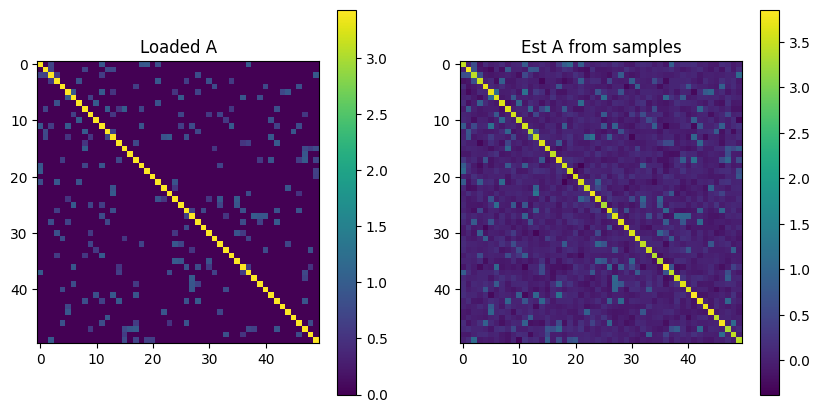

In [7]:
# Experiment parameters
N = 100
mean_deg = 5
p = mean_deg/(N-1)
weighted_edges = True
w_range = (.5, 1)
group_prop = [.25, .75]
M = int((N + mean_deg*N)*np.log(N))

# Create Graph
graph = nx.erdos_renyi_graph(N, p, directed=False)
A = nx.to_numpy_array(graph)
if weighted_edges:
    weights = np.random.uniform(w_range[0], w_range[1], size=A.shape)
    weights = np.tril(weights)
    A = (weights + weights.T) * A

# Precision matrix as loaded adjacency
max_eigenval = np.abs(la.eigvalsh(A)[0])

print('Max eigenval:', max_eigenval)

# A_loaded = (max_eigenval + .01) * np.eye(N) + A
A_loaded = (max_eigenval + .1) * np.eye(N) + A
assert np.all(la.eigvalsh(A_loaded) >= 0), 'Precision is not a PSD matrix'

# Create GMRF signals
mean = np.zeros(N)
Cov = la.inv(A_loaded)
X = np.random.multivariate_normal(mean, Cov, size=M).T
Cov_hat = X @ X.T / M

# Create 2 sensitive groups
Z = utils.create_Z(N, group_prop)

# Plot data
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
im1 = axes[0].imshow(A_loaded)
axes[0].set_title('Loaded A')
fig.colorbar(im1, ax=axes[0])
im2 = axes[1].imshow(la.inv(Cov_hat))
axes[1].set_title('Est A from samples')
fig.colorbar(im2, ax=axes[1])

print('Shape of X:', X.shape)

In [8]:
stepsize = 5e-3
epsilon = .1
mu1 = np.sqrt(np.log(N)/M) * .01
mu2 =  10*(N-1)
max_iters = 1000

print('Mu1:', mu1, 'Mu2:', mu2)

#####   DP - FISTA estimate   #####
bias_type = 'dp'
t_i = time.time()
A_fista, errs_A_fista = opt.FairGLASSO_fista(Cov_hat, mu1, stepsize, mu2, Z, bias_type, epsilon=epsilon,
                                           iters=max_iters, EARLY_STOP=True, RETURN_ITERS=True, prec_type='non-negative')
t_solved_fista = time.time() - t_i
np.fill_diagonal(A_fista, 0)
mean_A_fista = np.mean(utils.mat2lowtri(np.abs(A_fista)))
print(f'FISTA solved in {t_solved_fista:3f} secs')

#####   Nodewise - FISTA estimate   #####
bias_type = 'nodewise'
t_i = time.time()
A_fista_n, errs_A_fista_n = opt.FairGLASSO_fista(Cov_hat, mu1, stepsize, 0, Z, bias_type, epsilon=epsilon,
                                                 iters=max_iters, EARLY_STOP=True, RETURN_ITERS=True, prec_type='non-negative')
t_solved_fista_n = time.time() - t_i
np.fill_diagonal(A_fista_n, 0)
mean_A_fista_n = np.mean(utils.mat2lowtri(np.abs(A_fista_n)))
print(f'FISTA nodewise solved in {t_solved_fista_n:3f} secs')

#####   Graphical Lasso estimate   #####
t_i = time.time()
_, A_gl = graphical_lasso(Cov_hat, alpha=mu1, max_iter=max_iters, tol=1e-6)
t_solved_glasso = time.time() - t_i
np.fill_diagonal(A_gl, 0)
mean_A_gl = np.mean(utils.mat2lowtri(np.abs(A_gl)))
print(f'GL solved in {t_solved_glasso:3f} secs')

Mu1: 0.0005774996082805658 Mu2: 490
FISTA solved in 0.805032 secs
FISTA nodewise solved in 0.653278 secs
GL solved in 3.495294 secs


/home/srey/Investigacion/fair_GL/.venv/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:184: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: 3.121e-05
  warnings.warn(


Square fro err (naive): 0.152
FISTA: err: 0.129 | bias: 0.012 | time: 0.805
FISTA Node: err: 0.117 | bias: 0.298 | time: 0.653
GLASSO: err: 0.134 | bias: 0.202 | time: 3.495


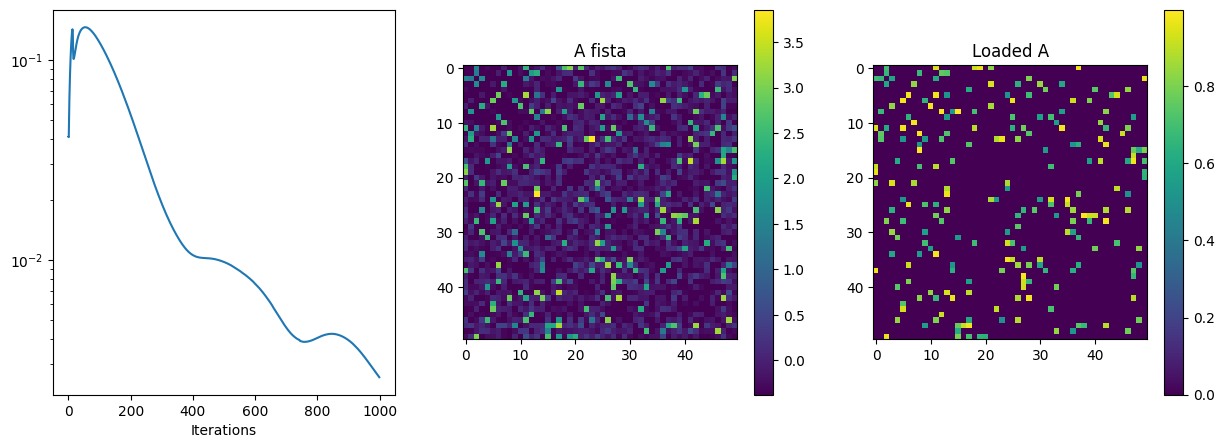

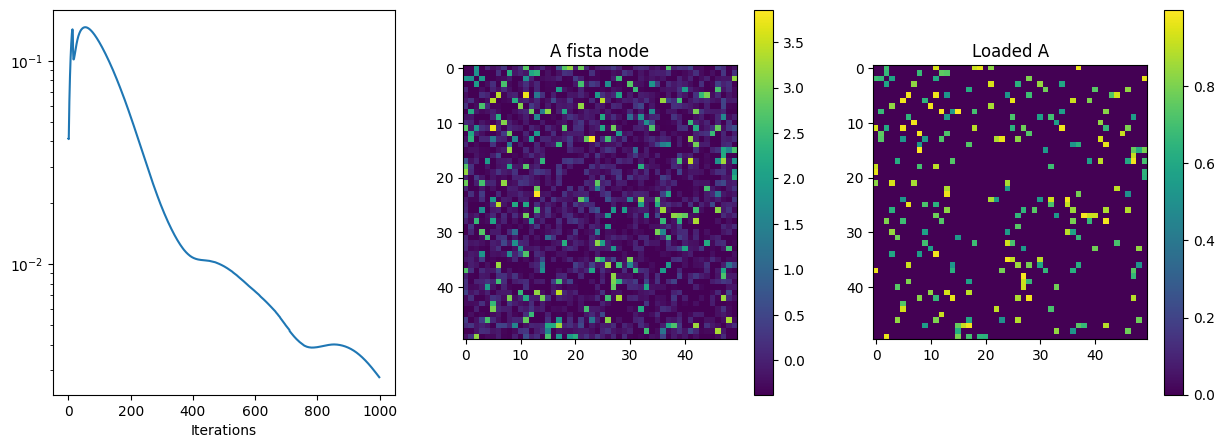

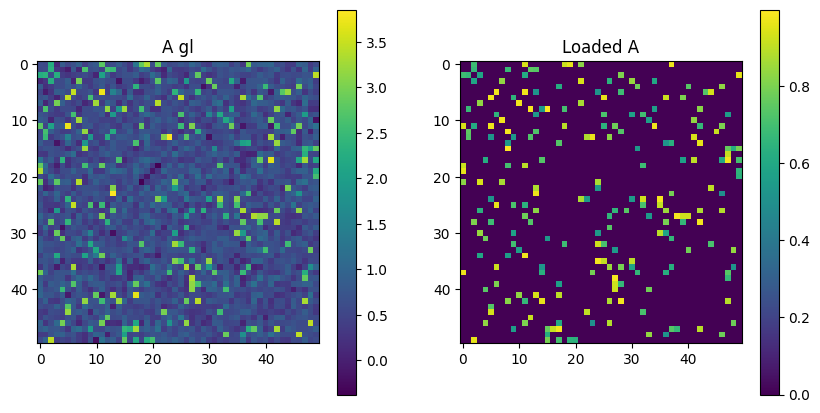

In [9]:
err_naive = norm_fro_err(la.inv(Cov_hat)*(1-np.eye(N)), A) **2
err_fista = norm_fro_err(A_fista, A) **2
err_fista_n = norm_fro_err(A_fista_n, A) **2
err_gl = norm_fro_err(A_gl, A_loaded) **2

bias_fista = np.sqrt(utils.compute_dp2(A_fista, Z)) / mean_A_fista if mean_A_fista else 0
bias_fista_n = np.sqrt(utils.compute_dp2(A_fista_n, Z)) / mean_A_fista_n if mean_A_fista_n else 0
bias_glasso = np.sqrt(utils.compute_dp2(A_gl, Z)) / mean_A_gl if mean_A_gl else 0

print(f'Square fro err (naive): {err_naive:.3f}')
print(f'FISTA: err: {err_fista:.3f} | bias: {bias_fista:.3f} | time: {t_solved_fista:.3f}')
print(f'FISTA Node: err: {err_fista_n:.3f} | bias: {bias_fista_n:.3f} | time: {t_solved_fista_n:.3f}')
print(f'GLASSO: err: {err_gl:.3f} | bias: {bias_glasso:.3f} | time: {t_solved_glasso:.3f}')


fig, axes = plt.subplots(1, 3, figsize=(15, 5))
im1 = axes[0].semilogy(errs_A_fista)
axes[0].set_xlabel('Err')
axes[0].set_xlabel('Iterations')
im = axes[1].imshow(A_fista)
axes[1].set_title('A fista')
fig.colorbar(im2, ax=axes[1])
im = axes[2].imshow(A)
axes[2].set_title('Loaded A')
fig.colorbar(im, ax=axes[2])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
im1 = axes[0].semilogy(errs_A_fista_n)
axes[0].set_xlabel('Err')
axes[0].set_xlabel('Iterations')
im = axes[1].imshow(A_fista_n)
axes[1].set_title('A fista node')
fig.colorbar(im2, ax=axes[1])
im = axes[2].imshow(A)
axes[2].set_title('Loaded A')
fig.colorbar(im, ax=axes[2])

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
im = axes[0].imshow(A_gl)
axes[0].set_title('A gl')
fig.colorbar(im2, ax=axes[0])
im = axes[1].imshow(A)
axes[1].set_title('Loaded A')
fig.colorbar(im, ax=axes[1])
